In [1]:
## Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
## LOAD DATA AND EXPLORATORY ANALYSIS

In [3]:
## Load dataset and drop unusefull columns
X_full = pd.read_csv('classes_dataset.csv', dtype={col: np.float32 for col in ['lcc', 'lcom*']})
X_full.shape

(50930, 15)

In [4]:
## Initial data treatment
X_full.drop(['refusedBequest'], axis=1, inplace=True)
X_full.drop(['Unnamed: 0'],axis=1,inplace=True)
X_full.dropna(inplace=True)
X_full.shape

(34115, 13)

In [5]:
## Show dataframe header
X_full.head(1)

,dit,fanin,fanout,lcc,lcom*,loc,noc,rfc,innerClassesQty,totalFieldsQty,totalMethodsQty,wmc,godClass
0,4,1,6,0.0,0.592593,39,0,12,0,3,9,10,0


In [6]:
## Is any empty feature?
np.any(np.isnan(X_full))

False

In [7]:
## SPLIT DATA

In [8]:
## Split dataset in metrics and godsmell ds
X = X_full.drop(['godClass'], axis=1)
y = X_full.godClass

In [9]:
SEED=0

In [10]:
## Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

In [11]:
## Show train size
X_train.shape

(27292, 12)

In [12]:
## Show test size
X_test.shape

(6823, 12)

In [13]:
## CREATE PIPELINE

In [15]:
## Import ML algorithm
from sklearn.naive_bayes import GaussianNB

In [17]:
## Create instance
nb = GaussianNB()

In [18]:
pipe = Pipeline(steps=[
    ('minmaxscaler', MinMaxScaler()),
    ('nb', nb)
])

In [19]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'minmaxscaler', 'nb', 'minmaxscaler__clip', 'minmaxscaler__copy', 'minmaxscaler__feature_range', 'nb__priors', 'nb__var_smoothing'])

In [26]:
# 100 possibilities
var_smoothing = np.logspace(0,-9, num=100)

parameters = dict(
    nb__var_smoothing=var_smoothing)

In [27]:
## TUNING THE MODEL

In [28]:
## Import libs
from sklearn.model_selection import RandomizedSearchCV, KFold

In [37]:
## Randomized Search Instance
randomized_search = RandomizedSearchCV(pipe,parameters,cv = KFold(n_splits=10),n_iter=100,random_state=SEED,scoring='neg_mean_squared_error')

In [38]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                             ('nb', GaussianNB())]),
                   n_iter=100,
                   param_distributions={'nb__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.5...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=0, scoring='neg_mean_squared_error')

In [39]:
resultados = pd.DataFrame(randomized_search.cv_results_)
resultados.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nb__var_smoothing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012493,0.000485,0.003052,0.000218,1.0,{'nb__var_smoothing': 1.0},-0.031136,-0.024542,-0.030781,-0.032246,-0.03188,-0.032613,-0.027849,-0.035178,-0.038109,-0.031513,-0.031585,0.003485,16
1,0.012515,0.000121,0.002954,0.000075,0.811131,{'nb__var_smoothing': 0.8111308307896871},-0.031136,-0.024908,-0.030781,-0.032246,-0.03188,-0.032613,-0.027849,-0.035178,-0.038109,-0.031513,-0.031621,0.003412,17


In [41]:
## Print best params
randomized_search.best_params_

{'nb__var_smoothing': 0.0533669923120631}

In [42]:
## Print best score
randomized_search.best_score_

-0.029092946872353243

In [43]:
## TRAINING THE BEST MODEL

In [44]:
## Traning best model
tuned_hyper_model= GaussianNB(var_smoothing=0.0533669923120631)
tuned_hyper_model.fit(X_train,y_train)

GaussianNB(var_smoothing=0.0533669923120631)

In [45]:
tuned_hyper_model.feature_importances_

AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'

In [46]:
feat_importances = pd.Series(tuned_hyper_model.feature_importances_, index=X_test.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'

In [47]:
## Prediction
y_pred=tuned_hyper_model.predict(X_test)

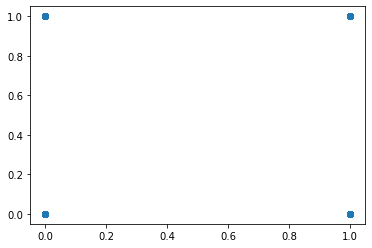

In [48]:
## Plot result
plt.scatter(y_test,y_pred)

In [49]:
## EVALUATE

In [50]:
## Evaluate error rate
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.029312619082515024
MSE: 0.029312619082515024
RMSE: 0.17120928445185157


In [51]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [52]:
accuracy_score(y_test, y_pred.round())

0.970687380917485

In [53]:
precision_score(y_test, y_pred.round())

0.6521739130434783

In [54]:
recall_score(y_test, y_pred.round())

0.14018691588785046

In [55]:
f1_score(y_test, y_pred.round())

0.23076923076923073